# Notebook de nettoyage et d’exploration

Mise en situation:  
Vous êtes en poste chez Datazon, et travaillez au sein de l'équipe marketing, avec d'autres Data Scientists. L'entreprise britannique, leader dans la vente en ligne de toute sorte d'objets, a tout intérêt à mieux comprendre les comportements de ses clients pour augmenter la fréquence d'achat et la valeur du panier moyen.  

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement dans la durée, afin de détecter les plus susceptibles de passer à l'achat.

les données brutes:  [Online Retail Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel("Online Retail.xlsx")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Attribute Information:**   
**- InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.   
**- StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.   
**- Description**: Product (item) name. Nominal.   
**- Quantity**: The quantities of each product (item) per transaction. Numeric.	  
**- InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.   
**- UnitPrice**: Unit price. Numeric, Product price per unit in sterling.   
**- CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.   
**- Country**: Country name. Nominal, the name of the country where each customer resides.  

When it comes to finding out who your best customers are, the old RFM matrix principle is the best. RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [5]:
# Check whether there are missing values in each column.
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
mask = df.loc[:, "Quantity"] < 0
mask.sum()

10624

In [7]:
# drop na in the main features
a = len(df)
df = df.dropna(subset=('InvoiceNo', 'StockCode', 'Quantity',
                       "InvoiceDate", 'UnitPrice', 'CustomerID'))
b = len(df)
print('{} ({}%) lines have been dropped for \
na in key features'.format((a-b), round((a-b)/a*100, 1)))

135080 (24.9%) lines have been dropped for na in key features


In [8]:
# drop duplicates
a = len(df)
df = df.drop_duplicates()
b = len(df)
print('{} ({}%) lines have been dropped for \
duplicates'.format((a-b), round((a-b)/a*100, 1)))

5225 (1.3%) lines have been dropped for duplicates


In [9]:
# Remove line where price = 0
a =  len(df)
mask = df.loc[:, "UnitPrice"] == 0
df = df.loc[~mask, :]
b = len(df)
print(' {} ({}%) lines have been dropped for \
UnitPrice = 0'.format((a-b), round((a-b)/a*100, 1)))

 40 (0.0%) lines have been dropped for UnitPrice = 0


### Remove cancel Orders
in fact, most orders with negative values in "Quantity" are tricks. the idea is to cancel an other "real" order with the same positive "Quantity". To clean the data base, we need to remove the orders of cancellation and reduce "quantity" of the original order. Note that it could also be interesting to keep it, to find any partern in it.

In [10]:
# remove_quantity from previous order
mask = df.loc[:, "Quantity"] <= 0
print("negative or zero values count:", mask.sum() )

neg_df= df.loc[mask, :]
idx_to_del = []

for idx in neg_df.index:
    mask = ((df.loc[:, "CustomerID"] == df.loc[idx, "CustomerID"]) &
              # (df.loc[:, "Quantity"] >= -df.loc[idx, "Quantity"]) &
            (df.loc[:, "StockCode"] == df.loc[idx, "StockCode"]) &
            (df.loc[:, "InvoiceDate"] < df.loc[idx, "InvoiceDate"]))
    try:
        # we take the last occurence: closest to the cancel order
        index_todel = df.loc[mask, :].tail(1).index[0] 
        df.loc[index_todel, "Quantity"] = (df.loc[index_todel, "Quantity"]
                                          + df.loc[idx, "Quantity"])  # <0
    except:
        continue

mask = df.loc[:, "Quantity"] <= 0
print("negative or zero values count after adjustement:", mask.sum() )

negative or zero values count: 8872
negative or zero values count after adjustement: 11580


In [11]:
# Drop cancel orders
a =  len(df)
df = df.loc[~mask, :]
b = len(df)
print('  {} ({}%) lines have been dropped for \
cancel orders'.format((a-b), round((a-b)/a*100, 1)))

  11580 (2.9%) lines have been dropped for cancel orders


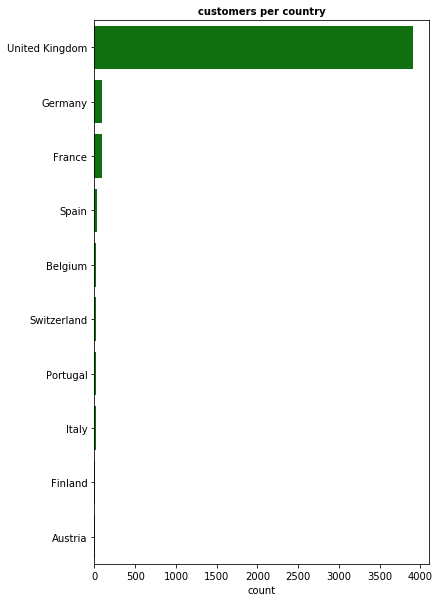

In [12]:
# customers per country
# inputs
df1 = df
customer_country = df1[['Country', 'CustomerID']].drop_duplicates()
x = customer_country["Country"].value_counts()[:10]
y = customer_country["Country"].value_counts().index[0:10]

# plot
plt.figure(figsize=(6, 10))
plt.title("customers per country", fontweight="bold", size=10)
sns.barplot(x=x, y=y, label="Total", color="g");
plt.xlabel("count")
plt.show()

We can clearly see that Uk is the main market.

In [13]:
x = df.groupby("StockCode").aggregate({"Quantity": len})
x.sort_values(by="Quantity")

,Quantity
StockCode,
77079,1
21839,1
85224,1
90165B,1
90021,1
90036F,1
90028,1
90176A,1
35597B,1


In [14]:
# remove non standard transaction , Post, Manual adjustement, Bank Charge
StockCode_to_remove = ("BANK CHARGES", "C2", "DOT", "M", "PADS", "POST")
mask = df.loc[:, "StockCode"].isin(StockCode_to_remove)
df = df.loc[~mask, :]

### features Engineering
We will creat some temporal variable such as month, hour or date (only). it will be used to agregate data on it, and explore some temporal paterns.

In [15]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df[:, 'month'] = pd.DatetimeIndex(df['InvoiceDate']).month
df[:, 'hours'] = pd.DatetimeIndex(df['InvoiceDate']).hour
df[:, 'date'] = pd.DatetimeIndex(df['InvoiceDate']).date

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [16]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,month,hours,date
526410,580667,85231B,CINAMMON SET OF 9 T-LIGHTS,3,2011-12-05 14:19:00,0.85,15031.0,United Kingdom,2.55,12,14,2011-12-05
384466,570126,22367,CHILDRENS APRON SPACEBOY DESIGN,1,2011-10-07 13:16:00,1.95,16910.0,United Kingdom,1.95,10,13,2011-10-07
151489,549556,22520,CHILDS GARDEN TROWEL BLUE,3,2011-04-10 12:53:00,0.85,17372.0,United Kingdom,2.55,4,12,2011-04-10
384554,570128,23344,JUMBO BAG 50'S CHRISTMAS,100,2011-10-07 13:21:00,1.79,13689.0,United Kingdom,179.00,10,13,2011-10-07
110125,545668,23052,RECYCLED ACAPULCO MAT TURQUOISE,1,2011-03-04 17:02:00,8.25,14031.0,United Kingdom,8.25,3,17,2011-03-04


In [23]:
def mode1(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]

In [24]:
modal_per_item = df.loc[:, ("StockCode", "UnitPrice")]
modal_per_item = modal_per_item.groupby("StockCode")
modal_per_item = modal_per_item.aggregate({"UnitPrice": mode1})

In [26]:
modal_per_item.head()

,UnitPrice
StockCode,
10002,0.85
10080,0.39
10120,0.21
10125,0.85
10133,0.42


In [32]:
# convert to dic
modal_per_item = dict(zip(modal_per_item.index,
                          modal_per_item.UnitPrice))

In [33]:
# creation of relative_price columns
# this columns indicate in percentage the get price of each order compar to the standard price

df["modal_price"] = 0
for stc, UnitPrice in modal_per_item.items():
    mask = df.loc[:, "StockCode"] == stc
    df.loc[mask, "modal_price"] = UnitPrice
    
df.loc[:, "relative_price"] = df.loc[:, "UnitPrice"]/df.loc[:, "modal_price"]
df.loc[:, "relative_price"] = df.loc[:, "relative_price"]*100
df.loc[:, "relative_price"] = df.loc[:, "relative_price"].astype("int")
df.loc[:, "relative_price"].head()

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ben\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5,1,'Relative price')

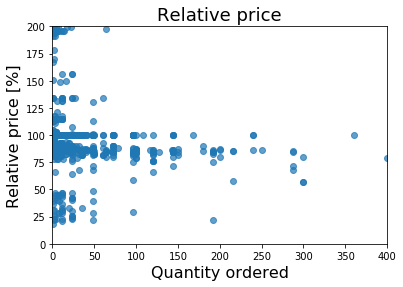

In [42]:
# Amount spend versus relative reduction

plt.scatter(x="Quantity",
            y="relative_price",
            data=df.sample(5000),
            alpha=0.7)
plt.xlim(0, 400)
plt.ylim(0, 200)
plt.title("")
plt.xlabel("Quantity ordered", size=16)
plt.ylabel("Relative price [%]", size=16)
plt.title("Relative price", size=18)

Reduction in priced are linked with relatively high quantity order. However the contrary is not true. Low quantity order does not always mean no reduction.

In [202]:
# temporal save
df.to_csv("customer seg df.csv")

In [2]:
# load point
df = pd.read_csv("customer seg df.csv")
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,month,hours,date,promo
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,8,2010-12-01,1
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,8,2010-12-01,1
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,8,2010-12-01,1
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,8,2010-12-01,1
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,8,2010-12-01,1


In [46]:
# create binary promo feature
import timeit
start_time = timeit.default_timer()

df.loc[:, "promo"] = 0
for stock_code, promo_UnitPrice in modal_per_item.items():
    mask = ((df.loc[:,"StockCode"] == stock_code)
          & (df.loc[:,"UnitPrice"] < promo_UnitPrice))
    df.loc[mask, "promo"] = 1
    
elapsed = timeit.default_timer() - start_time

C:\Users\ben\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [47]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,month,hours,date,modal_price,relative_price,promo
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,8,2010-12-01,2.95,86,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,8,2010-12-01,3.75,90,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,8,2010-12-01,4.15,66,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,8,2010-12-01,3.75,90,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,8,2010-12-01,4.25,79,1


### Invoice aggregation
In this section we will aggregate the previous table for each Invoice. 

In [48]:
Invoice_df = df.groupby("InvoiceNo").aggregate({"Quantity": "sum",
                                  "StockCode": "count",
                                  "TotalPrice": "sum",
                                  "CustomerID": "min",
                                  "Country": "min",
                                   "month": "min",
                                  "hours": "min",
                                  "date": "min",
                                  "promo": "mean"})
Invoice_df.rename(columns={"StockCode": "nb_item_types"}, inplace=True)
Invoice_df.sample(3)

,Quantity,nb_item_types,TotalPrice,CustomerID,Country,month,hours,date,promo
InvoiceNo,,,,,,,,,
541552,755,39,733.34,15039.0,United Kingdom,1,11,2011-01-19,0.256410
561859,525,19,188.49,17750.0,United Kingdom,7,17,2011-07-29,0.105263
579441,17,4,221.90,12464.0,Belgium,11,13,2011-11-29,0.500000


### Exploration  invoices

C:\Users\ben\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


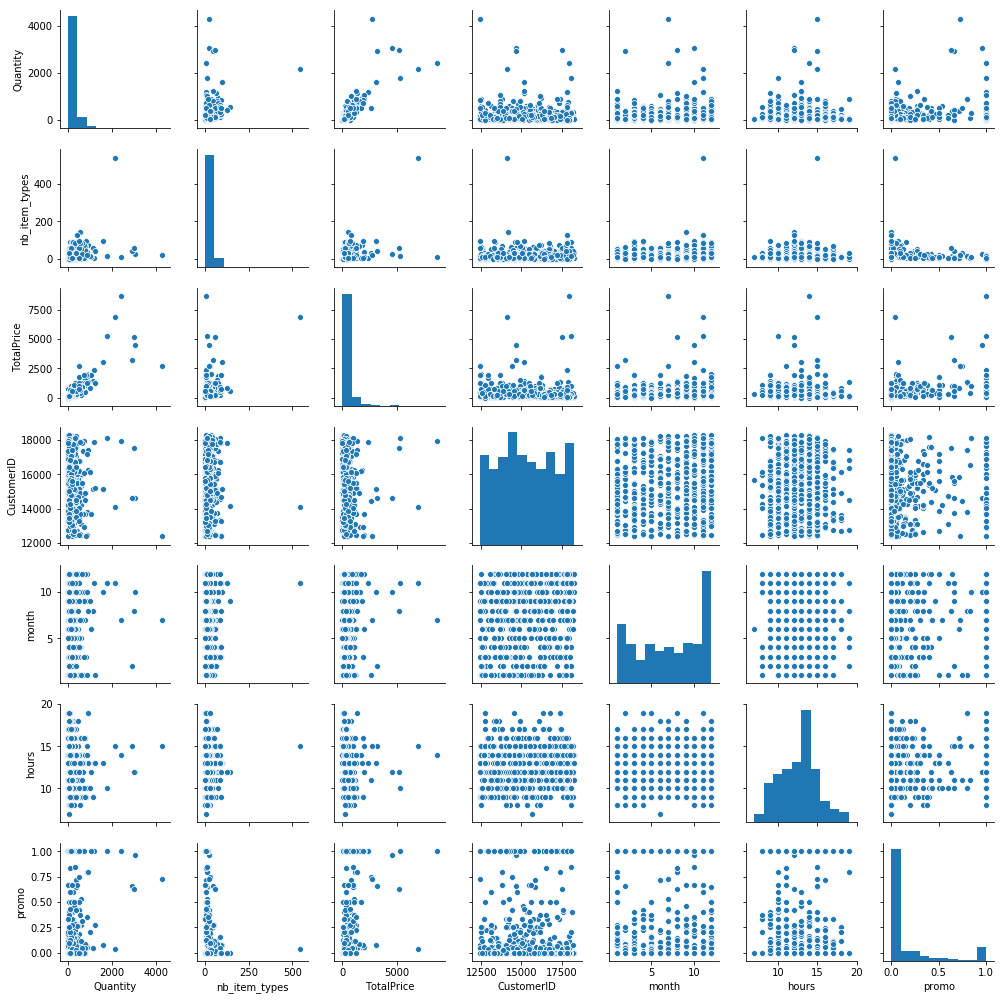

In [49]:
# look for any correlation in between features
x = Invoice_df.drop(axis=1, columns=["date", "Country"]).sample(500)
sns.pairplot(x, size=2);

There is clear relationsheep in between TotalPrice and Quantity.

Order seems to increase at the end of the year (close to Christmas)

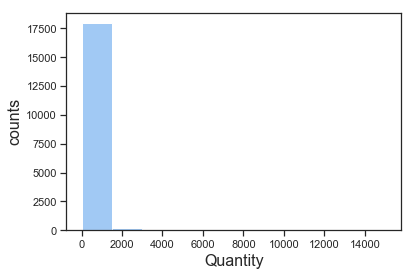

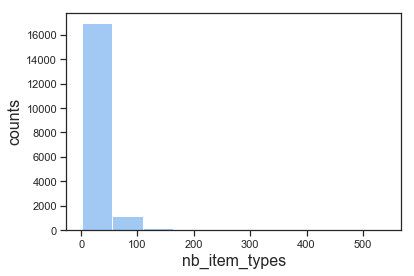

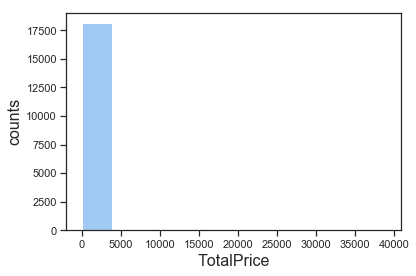

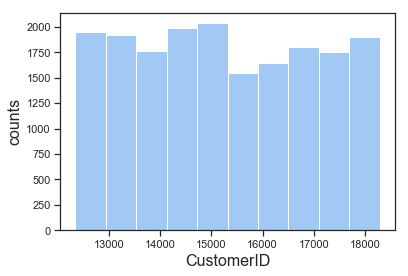

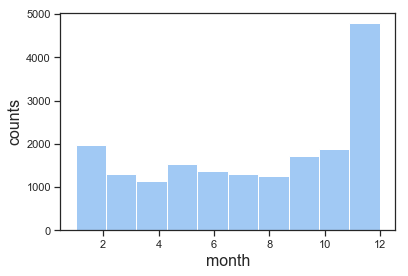

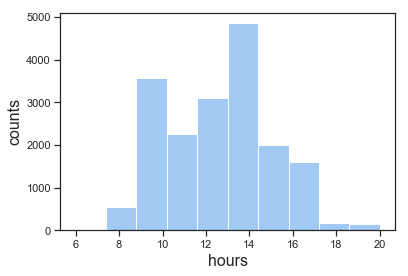

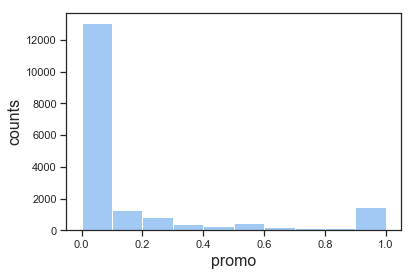

In [50]:
# plot x distribution
import matplotlib.pyplot as plt
import seaborn as sns

# inputs
xn = Invoice_df.select_dtypes(exclude=['object'])

# plot
sns.set(style="ticks", palette="pastel")
for i,x in enumerate(xn):
    plt.figure(figsize=(6, 4))
    plt.hist(xn[x].dropna())
    plt.ylabel('counts', size=16)
    plt.xlabel(xn.columns.values[i], size=16)
    plt.show()

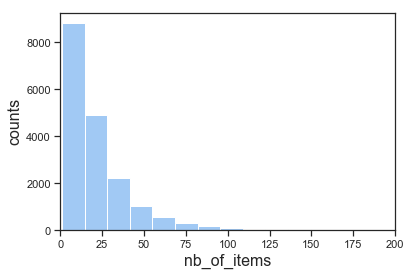

In [57]:
# Zoom on nb_of_items
plt.figure(figsize=(6, 4))
plt.hist(Invoice_df.nb_item_types, bins=40)
plt.ylabel('counts', size=16)
plt.xlabel("nb_of_items", size=16)
plt.xlim(0,200)
plt.show()

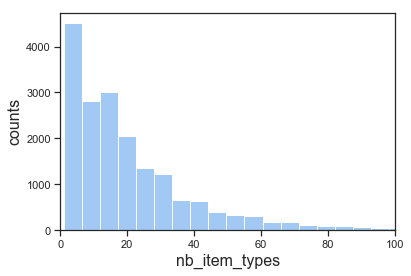

In [58]:
# Zoom on nb_of_items
plt.figure(figsize=(6, 4))
plt.hist(Invoice_df.nb_item_types, bins=100)
plt.ylabel('counts', size=16)
plt.xlabel("nb_item_types", size=16)
plt.xlim(0,100)
plt.show()

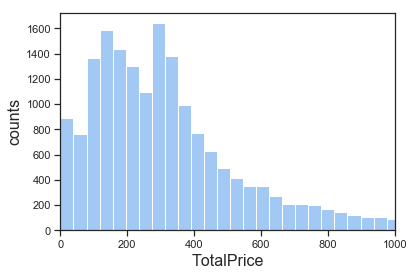

In [60]:
# Zoom on nb_of_items
plt.figure(figsize=(6, 4))
plt.hist(Invoice_df.TotalPrice, bins=1000)
plt.ylabel('counts', size=16)
plt.xlabel("TotalPrice", size=16)
plt.xlim(0,1000)
plt.show()

Pic at 300 £. Could be free shiping limits ?

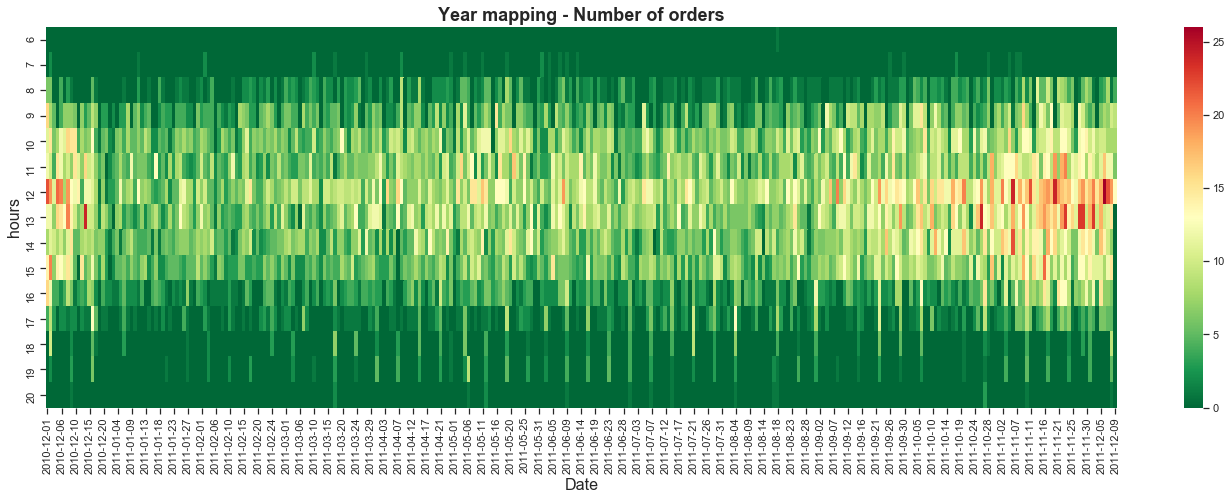

In [64]:
# Nb of orders during the year
x = Invoice_df.loc[:, ("TotalPrice","date", "hours")].pivot_table(values="TotalPrice", 
                                                             index='hours',
                                                             columns='date',  
                                                             aggfunc= len, 
                                                             fill_value=0)
# delays along the years
plt.figure(figsize=(24,7))
plt.title("Year mapping - Number of orders", fontweight="bold", size=18)
sns.heatmap(x, annot=False, cmap="RdYlGn_r")   # 
plt.xlabel("Date", size=16)
plt.ylabel("hours", size=16)
plt.show()

In [75]:
Invoice_df['day_of_the_week'] = pd.to_datetime(Invoice_df['date']).dt.weekday
Invoice_df["day_of_the_week"].value_counts()

3    3979
2    3418
1    3133
0    2806
4    2787
6    2158
Name: day_of_the_week, dtype: int64

No invoice the saturday. missing data ?

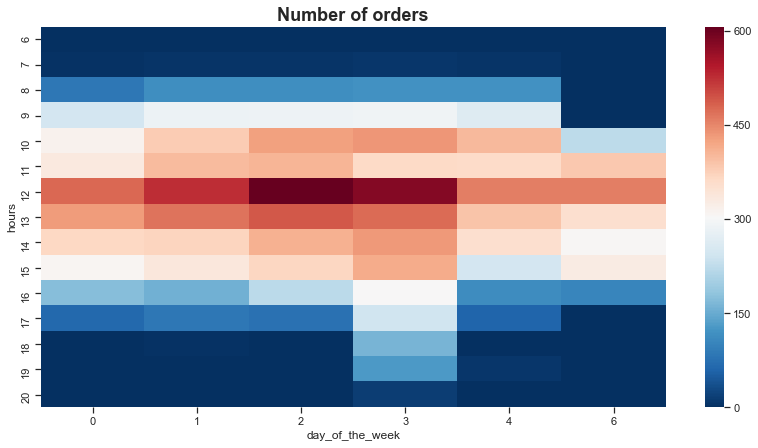

In [76]:
# Nb of orders over the day of the week
x = Invoice_df.loc[: ,("TotalPrice","day_of_the_week","hours")].pivot_table(values = "TotalPrice", 
                                                             index='hours',
                                                             columns='day_of_the_week',  
                                                             aggfunc=len, 
                                                             fill_value=0)
# delays along the years
plt.figure(figsize=(14,7))
plt.title("Number of orders", fontweight="bold", size=18)
sns.heatmap(x, annot=False, cmap = "RdBu_r")   # RdYlGn_r
plt.show()

(0, 800)

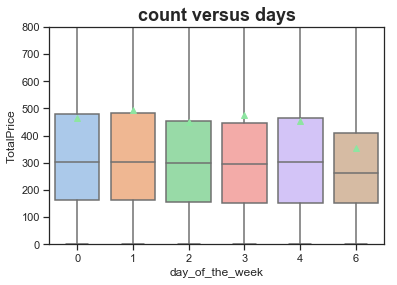

In [77]:
# cash in distribution over week days
plt.title("count versus days", fontweight="bold", size = 18)
sns.boxplot(x="day_of_the_week", y="TotalPrice", data=Invoice_df,showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,800)

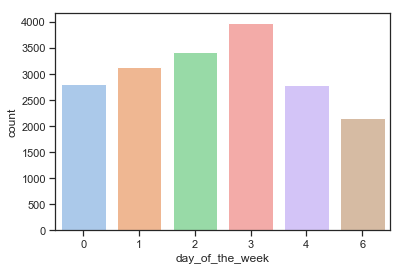

In [78]:
# number of orders by day
sns.countplot(Invoice_df["day_of_the_week"])

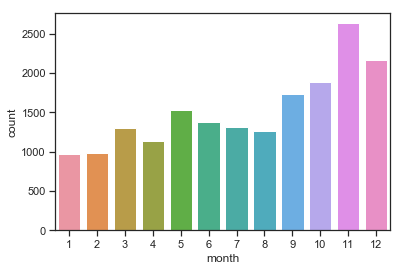

In [79]:
#number of order per month
sns.countplot(Invoice_df["month"])

### Agregation per customer

In [102]:
# build frequency and recency per customer
import datetime as dt

NOW = df.loc[:, "InvoiceDate"].max().date()   # max(date) in the data
rfmTable = df.groupby('CustomerID').agg({'date': lambda x: (NOW - x.max()).days, 
                                          'InvoiceNo':  lambda x: len(set(x))})

rfmTable.rename(columns={'date': 'recency', 
                         'InvoiceNo': 'frequency'}, inplace=True)

rfmTable.head(3)

,recency,frequency
CustomerID,,
12347.0,2,7
12348.0,75,4
12349.0,18,1


In [103]:
# add average promo per customer
promo_hunter = df.groupby("CustomerID").agg({"promo": np.mean})
customer_df = pd.merge(rfmTable,
                       promo_hunter,
                       left_index=True,
                       right_index=True)
customer_df.head(3)

,recency,frequency,promo
CustomerID,,,
12347.0,2,7,0.065934
12348.0,75,4,0.148148
12349.0,18,1,0.000000


In [104]:
# add basket (price) information (total, average, standard deviation) per customer

# 1.Basket
total_basket = Invoice_df.groupby("CustomerID").agg({"TotalPrice": np.sum})
avg_basket = Invoice_df.groupby("CustomerID").agg({"TotalPrice": np.mean})
std_basket = Invoice_df.groupby("CustomerID").agg({"TotalPrice": np.std})

total_basket.rename(columns={'TotalPrice': 'total_basket'}, inplace=True)
avg_basket.rename(columns={'TotalPrice': 'avg_basket'}, inplace=True)
std_basket.rename(columns={'TotalPrice': 'std_basket'}, inplace=True)

customer_df = pd.merge(customer_df, total_basket, left_index=True, right_index=True)
customer_df = pd.merge(customer_df, avg_basket, left_index=True, right_index=True)
customer_df = pd.merge(customer_df, std_basket, left_index=True, right_index=True)

customer_df.head(3)

,recency,frequency,promo,total_basket,avg_basket,std_basket
CustomerID,,,,,,
12347.0,2,7,0.065934,4310.00,615.714286,341.070789
12348.0,75,4,0.148148,1437.24,359.310000,203.875689
12349.0,18,1,0.000000,1457.55,1457.550000,NaN


In [105]:
# Add items types(total, average, standard deviation) per customer

total = df.groupby("CustomerID").agg({"StockCode": lambda x: len(set(x))})
avg = Invoice_df.groupby("CustomerID").agg({"nb_item_types": np.mean})
std = Invoice_df.groupby("CustomerID").agg({"nb_item_types": np.std})

total.rename(columns={'StockCode': 'total_nb_d_items'}, inplace=True)
avg.rename(columns={'nb_item_types': 'avg_nb_d_items'}, inplace=True)
std.rename(columns={'nb_item_types': 'std_nb_d_items'}, inplace=True)

customer_df = pd.merge(customer_df, total, left_index=True, right_index=True)
customer_df = pd.merge(customer_df, avg, left_index=True, right_index=True)
customer_df = pd.merge(customer_df, std, left_index=True, right_index=True)

customer_df.head(3)

,recency,frequency,promo,total_basket,avg_basket,std_basket,total_nb_d_items,avg_nb_d_items,std_nb_d_items
CustomerID,,,,,,,,,
12347.0,2,7,0.065934,4310.00,615.714286,341.070789,103,26.00,11.430952
12348.0,75,4,0.148148,1437.24,359.310000,203.875689,21,6.75,6.291529
12349.0,18,1,0.000000,1457.55,1457.550000,NaN,72,72.00,NaN


In [106]:
# add Quantity (total, average, standard deviation) per customer
total = df.groupby("CustomerID").agg({"Quantity": np.sum})
avg = Invoice_df.groupby("CustomerID").agg({"Quantity": np.mean})
std = Invoice_df.groupby("CustomerID").agg({"Quantity": np.std})

total.rename(columns={'Quantity': 'total_quantity'}, inplace=True)
avg.rename(columns={'Quantity': 'avg_quantity'}, inplace=True)
std.rename(columns={'Quantity': 'std_quantity'}, inplace=True)

customer_df = pd.merge(customer_df, total, left_index=True, right_index=True)
customer_df = pd.merge(customer_df, avg, left_index=True, right_index=True)
customer_df = pd.merge(customer_df, std, left_index=True, right_index=True)

customer_df.head(3)

,recency,frequency,promo,total_basket,avg_basket,std_basket,total_nb_d_items,avg_nb_d_items,std_nb_d_items,total_quantity,avg_quantity,std_quantity
CustomerID,,,,,,,,,,,,
12347.0,2,7,0.065934,4310.00,615.714286,341.070789,103,26.00,11.430952,2458,351.142857,173.277647
12348.0,75,4,0.148148,1437.24,359.310000,203.875689,21,6.75,6.291529,2332,583.000000,474.843132
12349.0,18,1,0.000000,1457.55,1457.550000,NaN,72,72.00,NaN,630,630.000000,NaN


### Exploration: customers

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


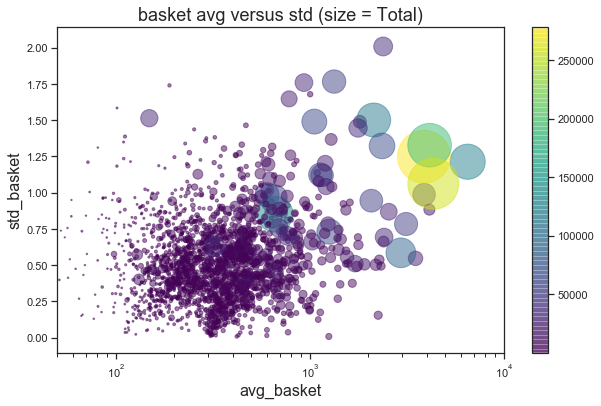

In [118]:
# Scatter basket
# Inputs
mask = customer_df.loc[:, "frequency"] > 2
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_basket"]/x["avg_basket"]  # normalised STD
sizes = x["total_basket"]/100

# plot
plt.figure(figsize=(10, 6))
plt.scatter(x="avg_basket", 
            y="turbulence", 
            cmap='viridis', 
            data=x, 
            s=sizes, 
            alpha=0.5, 
            c="total_basket")

plt.title("basket avg versus std (size = Total)", size=18)
plt.xlabel("avg_basket", size=16)
plt.ylabel("std_basket", size=16)
plt.xlim(50,10000)
plt.xscale('log')
plt.colorbar()
plt.show()

We can see that big Total basket cusomers have in general big average basket. Note also thier standard deviation in the basket size is higher than the "average customer".

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


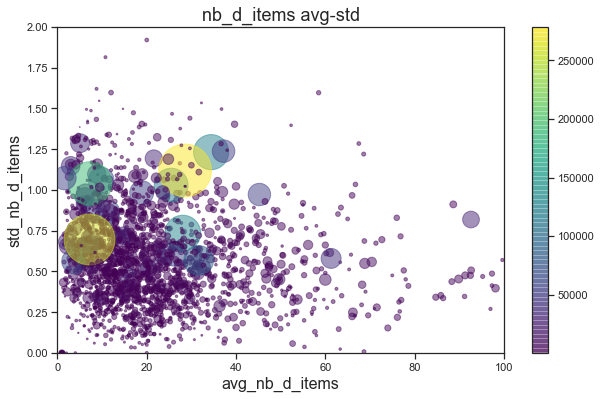

In [119]:
# Scatter avg_nb_d_items
# Inputs
mask = customer_df.loc[:, "frequency"] > 2
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_nb_d_items"]/x["avg_nb_d_items"]
sizes = x["total_basket"]/100


plt.figure(figsize=(10, 6))
plt.scatter(x="avg_nb_d_items", 
            y="turbulence", 
            cmap='viridis', 
            data=x, 
            s=sizes, 
            alpha=0.5, 
            c="total_basket")
plt.xlim(0,100)
plt.ylim(0,2)
plt.title("nb_d_items avg-std", size=18)
plt.xlabel("avg_nb_d_items", size=16)
plt.ylabel("std_nb_d_items", size=16)
plt.colorbar()
plt.show()

High Number of the average number of items per command means in general relatively big

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


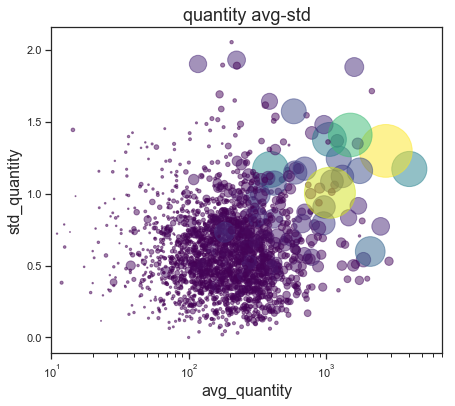

In [121]:
# Scatter quantity
# Inputs
mask = customer_df.loc[:, "frequency"] > 2
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_quantity"]/x["avg_quantity"]

sizes = x["total_basket"]/100

plt.figure(figsize=(7, 6))
plt.scatter(x="avg_quantity", 
            y="turbulence", 
            cmap='viridis', 
            data=x, 
            s=sizes, 
            alpha=0.5,
            c="total_basket")
plt.xlim(10,7000)
#plt.ylim(0,2)
plt.title("quantity avg-std", size=18)
plt.xlabel("avg_quantity", size=16)
plt.ylabel("std_quantity", size=16)
plt.xscale('log')
plt.show()

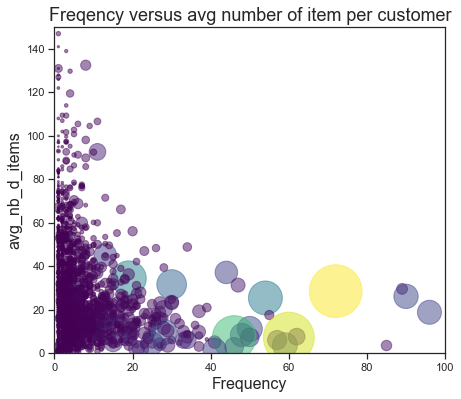

In [124]:
# Scatter avg_nb_d_items
# Inputs
mask = customer_df.loc[:, "frequency"] > 0
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_nb_d_items"]/x["avg_nb_d_items"]
sizes = x["total_basket"]/100

plt.figure(figsize=(7, 6))
plt.scatter(x="frequency", 
            y="avg_nb_d_items", 
            cmap='viridis', 
            data=x, 
            s=sizes, 
            alpha=0.5, 
            c="total_basket")
plt.xlim(0,100)
plt.ylim(0,150)
plt.title("Freqency versus avg number of item per customer", size=18)
plt.xlabel("Frequency", size=16)
plt.ylabel("avg_nb_d_items", size=16)
plt.show()

High average number of item type (>40) per command, are in genaral linked with low frequency. Big customer seems to order less item but more often.

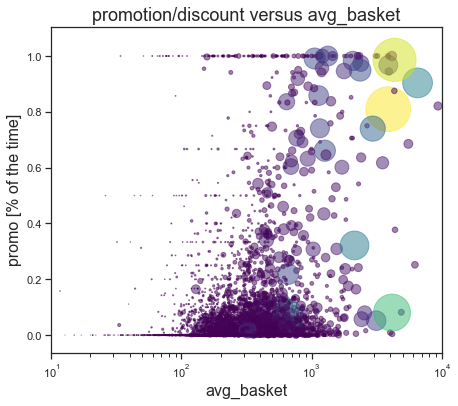

In [161]:
# Scatter avg_nb_d_items
# Inputs
mask = customer_df.loc[:, "frequency"] > 0
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_nb_d_items"]/x["avg_nb_d_items"]
sizes = x["total_basket"]/x["total_basket"].max()*2000

plt.figure(figsize=(7, 6))
plt.scatter(x="avg_basket", 
            y="promo", 
            cmap='viridis', 
            data=x, 
            s=sizes, 
            alpha=0.5, 
            c="total_basket")
plt.xlim(10,10000)
# plt.ylim(0,70)
plt.title("promotion/discount versus avg_basket", size=18)
plt.xlabel("avg_basket", size=16)
plt.ylabel("promo [% of the time]", size=16)
plt.xscale("log")
plt.show()

In [157]:
x["total_basket"].max()

278742.01999999996

In [294]:
# scatter-hist plot function (x,y,z)
def scat_plot(df=customer_df ,x_name="avg_basket", y_name="std_basket", 
              z_name="total_basket", xlog=False, ylog=False, xlim=(None, None), 
              ylim=(None, None), title=None):

    # Scatter avg_nb_d_items
    # Inputs
    sizes = df.loc[:, z_name]/df[z_name].max()*2000   # max size = 2000

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(10, 10))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[1:-1, :3])  # same notation than iterable "-" = from the end
    y_hist = fig.add_subplot(grid[1:-1, 3], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[0, :3], yticklabels=[], sharex=main_ax)
    z_hist = fig.add_subplot(grid[0, 3], yticklabels=[])
   
    # Main plot
    main_ax.scatter(x=x_name,
                    y=y_name,
                    cmap='viridis',
                    data=df,
                    s=sizes,
                    alpha=0.5,
                    c=z_name)
    # main_ax.axis(v='tight')
    # main_ax.autoscale(True)
    main_ax.set_label("XXX")
    main_ax.set_ylabel(y_name, size=16)
    main_ax.set_xlabel(x_name, size=16 )
    main_ax.set_xlim(xlim[0], xlim[1])
    main_ax.set_ylim(ylim[0], ylim[1])
    
    # histogram on the attached axes
    x_hist.hist(df[x_name], 40, histtype='stepfilled',
                orientation='vertical', color = "purple")
    x_hist.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off


    y_hist.hist(df[y_name], 30, histtype='stepfilled',
                orientation='horizontal', color = "purple")
    y_hist.tick_params( axis='y',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        left=False,         # ticks along the top edge are off
                        labelleft=False) # labels along the bottom edge are off
    
    z_hist.hist(df[z_name], 40, histtype='stepfilled',
                orientation='vertical', color = "purple")
    z_hist.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        left=False,         # ticks along the top edge are off
                        labelleft=False,
                        labelbottom=False) # labels along the bottom edge are off
    z_hist.set_xlabel(z_name, size=10 )
    
    if xlog == True:
        main_ax.set_xscale("log")
    if ylog == True:
        main_ax.yscale("log")
    fig.suptitle(title, size=18)
    plt.show();


C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


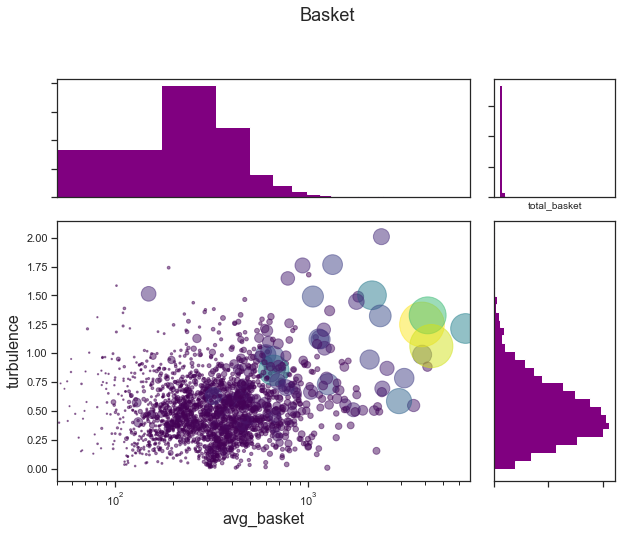

In [295]:
# Basket plot
mask = customer_df.loc[:, "frequency"] > 2
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_basket"]/x["avg_basket"]

scat_plot(df=x, y_name="turbulence", xlim=(50, None), xlog=True, title="Basket")

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


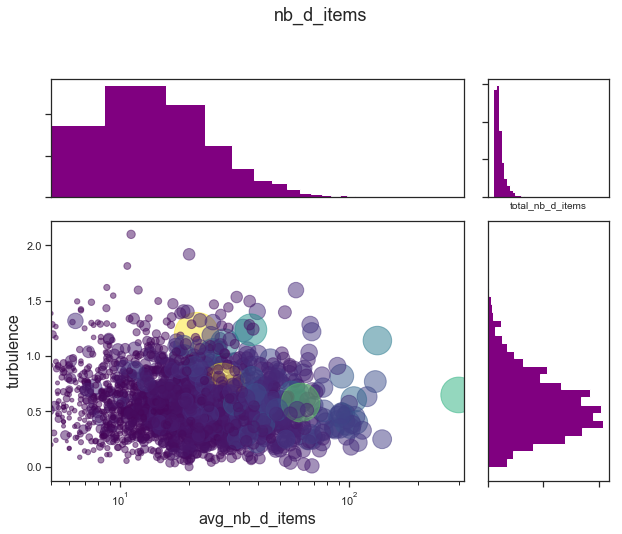

In [296]:
# nb_d_item plot
mask = customer_df.loc[:, "frequency"] > 2
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_nb_d_items"]/x["avg_nb_d_items"]

scat_plot(df=x,
          x_name="avg_nb_d_items", 
          y_name="turbulence", 
          z_name="total_nb_d_items",
          title="nb_d_items",
          xlog=True,
          xlim=(5,None))

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


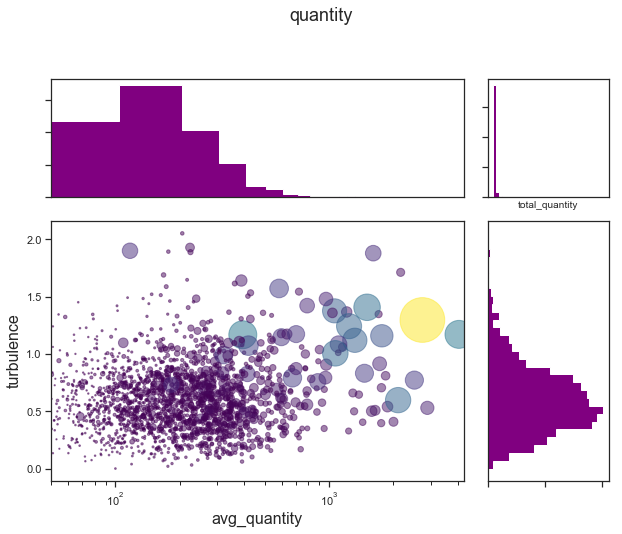

In [300]:
# quantity plot
mask = customer_df.loc[:, "frequency"] > 2
x = customer_df.loc[mask, :]
x["turbulence"] = x["std_quantity"]/x["avg_quantity"]

scat_plot(df=x,
          x_name="avg_quantity", 
          y_name="turbulence", 
          z_name="total_quantity",
          title="quantity",
          xlog=True,
          xlim=(50,None))

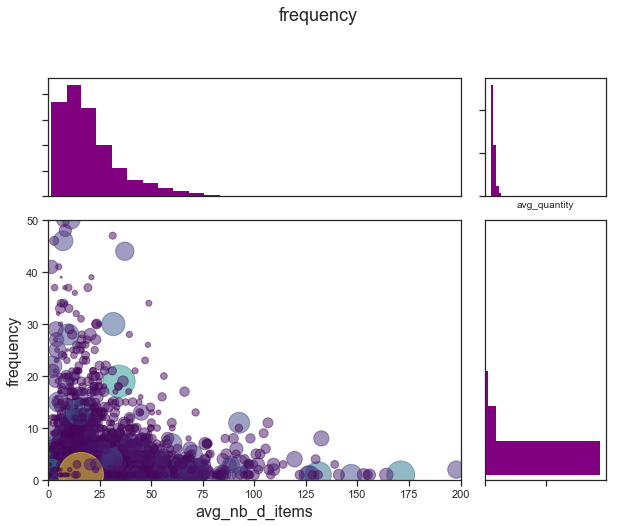

In [339]:
# frequency
scat_plot(df=customer_df,
          x_name="avg_nb_d_items",
          y_name="frequency",
          z_name="avg_quantity",
          title="frequency",
          xlim=(0,200),
          ylim=(0,50))

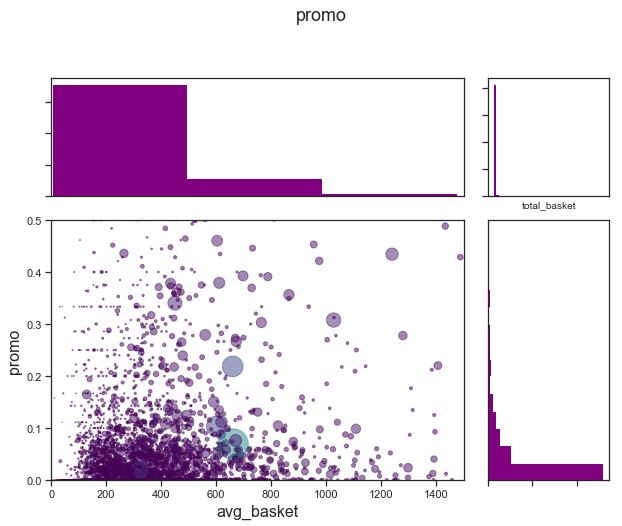

In [338]:
# promo
scat_plot(df=customer_df,
          x_name="avg_basket",
          y_name="promo",
          z_name="total_basket",
          title="promo",
          xlim=(0, 1500),
           ylim=(0,0.5))

In [341]:
# export customer_df
customer_df.to_csv("customer_df.csv")